In [1]:
# Install NetworkX
import sys
!{sys.executable} -m pip install networkx==2.3

In [2]:
# Install matplotlib
!{sys.executable} -m pip install matplotlib

In [3]:
# Imports
import sys
import math
import unittest
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
G = nx.Graph() #tworzę graf

x1=0
x2=1
y1=0
y2=1
z1=0
z2=1

# Typ wierzchołka musi być wyróżniony
# w tym podejdziu zwykły wierzchołek zaczyna się na v, a hanging node na h
# jak widać w kodzie poniżej identyfikujemy typ po pierwszej literze

#           id,   x,    y,    z
G.add_node("v1", x=x1, y=y1, z=z1) #dodajemy wierzchołek
G.add_node("v2", x=x2, y=x2, z=z2) #dodajemy drugi wierzchołek
G.add_edge("v2", "v1") #dodajemy krawędź między wierzchołkami

v1 = G.nodes["v1"] #pobieramy wierzchołek który będzie nas interesował w kontekście krawędzi
v2 = G.nodes["v2"] #drugi wierzchołek krawędzi
attrs = {} #tak dodajemy atrybuty dla krawędzi, a krawędź ma atrybuty l i b
nx.set_edge_attributes(G, attrs) #aplikujemy atrybuty na krawędź

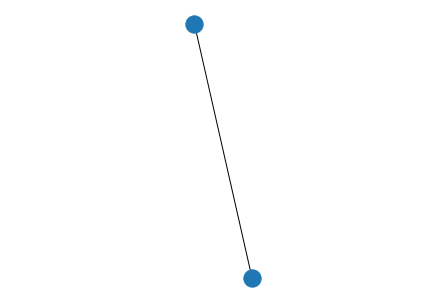

In [5]:
nx.draw(G)

zadanie polega na wyszukaniu w grafie, który został podany w sposób podany wyżej grafu, który spełnia warunki zadania

trójkąt o którym mowa może mieć hanging node, czyli specyficzny werzchołek, z którego nie ma połączenia do wnętrza, a który leży pomiędzy krawędziami

każde zadanie może mieć inne warunki na ilość hanging nodów

na wejście dostajemy id wierzchołka I, czyli tego środkowego

algorytm postępowania:

1. dostajemy i oraz G
2. znajdujemy sąsiadów i jeśli sąsiadów jest liczba mniejsza niż 3 to zwracamy false
3. jeśli jest 3 sąsiadów to określ trójkąt czyli połącznia między v1 v2 v3
4. L1=neighbours (v1, G)
5. L2=neighbours (v2, G)
6. if v1 należy do L2 i v2 należy do L1 (czyli jeśli jest pojedyncza krawędź) zwróć ją
7. else common=L1 przecięcie L2 i jeśli neighbour v1 jest hanging node i należy do common to zwróć dwie krawędzie - v1 z h i v2 z h, wpp. zwróć false

In [6]:
# Funkcja do budowania dicta ze współrzędnymi
# Taki dict jest wymagany przez funkcję rysującą
# jeżeli chcemy mieć poprawne rozmieszczenie
def build_pos_dict(G):
    xs = nx.get_node_attributes(G,'x')
    ys = nx.get_node_attributes(G,'y')

    keys = xs.keys()
    values = zip(xs.values(), ys.values())
    pos = dict(zip(keys, values))
    
    return pos

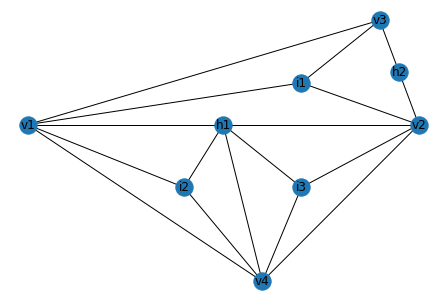

In [7]:
# Na wejściu dostajemy jakiś bardzo duży graf, który jest jakoś tam reprezentowany (na razie nie wiemy jak).
# Zakładamy jednak że mamy jakieś funkcje które parsują wejście i zwracają nam wszystkie potrzebne 
# dane, np w postaci dicta.
# Ogólnie to możemy założyć że wszystkie dane potrzebne do zbudowania grafu wejściowego są nam po prostu dostępne
# Poniżej graf na którym można testować swoje rozwiązanie

def get_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0), 
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}

    G.add_edge("v1", "h1", length = 5, name = 'e1')
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2')
    G.add_edge("v2", "h1", length = 5, name = 'e3')
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4')
    G.add_edge("v3", "v1", length = 13.4536, name = 'e5')
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6')
    G.add_edge("v2", "i1", length = 5, name = 'e7')
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8')
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9')
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10')
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11')
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12')
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13')
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14')
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15')
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16')
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17')
    
    nx.set_node_attributes(G, attrs)
    
    return G

# NetworkX: aby narysować graf z dobrym rozmieszczeniem, musimy przekazać
# sam graf oraz osobno dict z współrzędnymi (x,y)
G = get_test_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

powstał na górze graf przykładowy, który wskazał dr. Paszyński jako przykład, że jak z tym sobie program poradzi to ze wszystkim sobie poradzi

i teraz weźmy sobie zadanie P7 - patrząc na nie - potrzebujemy ten trójkąt v1 v2 v3 i ono spełnia nasze warunki

In [8]:
def find_graph_P7(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która nie ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[0]
        v2 = list(G.neighbors(i))[1]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node=None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            edge_without_hanging_node = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node)
    
    
    # sprawdzenie zadanego warunku:
    if (e1==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e2==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e3==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']):
        return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #nowy punkt V:
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
    print ("nowy punkt v będzie się nazywał: " + new_v_node)
    G.add_node(new_v_node)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e1==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v1 a v2")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v2)]
        G.remove_edge(v1, v2)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v2, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.node[v3]['x'] - new_x, 2) + math.pow(G.node[v3]['y'] - new_y, 2))
        G.add_edge(new_v_node, v3)
        
    elif (e2==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v2 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v3,v2)]
        G.remove_edge(v2, v3)
        
        new_x = (G.node[v3]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v3]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v3]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v2, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        #add new i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);  
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v1]['x'] - new_x, 2) + math.pow(G.node[v1]['y'] - new_y, 2))
        G.add_edge(new_v_node, v1, length=last_edge_length)
        
    elif (e3==edge_without_hanging_node):
        print("nowy wierzcholek ma byc miedzy v1 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v3)]
        G.remove_edge(v1, v3)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v3]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v3]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v3]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v2]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v2]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v2]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);                                                                          
        attrs[new_i_node] = {'R': False}                                                                          
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v2]['x'] - new_x, 2) + math.pow(G.node[v2]['y'] - new_y, 2))
        G.add_edge(new_v_node, v2, length=last_edge_length)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True
    

[{'length': 5, 'name': 'e1'}, {'length': 5, 'name': 'e3'}]
[{'length': 5.0249, 'name': 'e2'}, {'length': 5.0249, 'name': 'e4'}]
{'length': 13.4536, 'name': 'e5'}
{'length': 13.4536, 'name': 'e5'}
nowy punkt v będzie się nazywał: v5
nowy punkt i będzie się nazywał: i4
nowy punkt i będzie się nazywał: i5
nowy wierzcholek ma byc miedzy v1 a v3
True


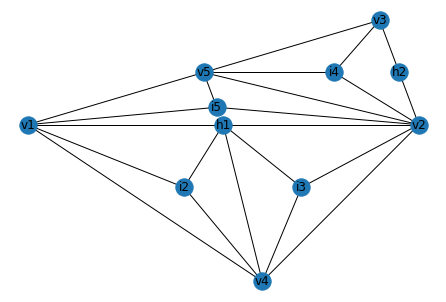

In [9]:
G = get_test_graph()
print(find_graph_P7(G, "i1"))